In [1]:
import sys
from pathlib import Path
import subprocess
import os
import gc
from glob import glob
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import polars as pl
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GroupKFold, StratifiedGroupKFold
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer

import warnings
warnings.filterwarnings('ignore')

In [2]:
start_time_utc = datetime.datetime.now()
print(f'Notebook Start Time (UTC): {start_time_utc}')

Notebook Start Time (UTC): 2024-09-20 07:52:41.996834


In [3]:
class Pipeline:

    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int64))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))
        return df

    def handle_dates(df):
        base_date = datetime.datetime(1900, 1, 1)
        for col in df.columns:
            if col[-1] in ("D",):
                days_since_base = (pl.col(col) - pl.lit(base_date)).dt.days()
                df = df.with_columns(
                 days_since_base.alias(col + "_days_since_1900_D")
                )
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))  #!!?
                df = df.with_columns(pl.col(col).dt.total_days()) # t - t-1
        df = df.drop("date_decision", "MONTH")
        return df

    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()
                if isnull > 0.98:
                    df = df.drop(col)
        
        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()
                if (freq == 1) | (freq > 10000):
                    df = df.drop(col)
                elif freq>200:
                    top_20_frequency = (
                        df.group_by(col)
                          .agg(pl.count(col).alias("counts"))
                          .sort("counts", descending=True)
                          .head(20)
                    )
                    value_name = top_20_frequency[col].to_list()
                    sum_top_20 = top_20_frequency['counts'].sum()
                    total_non_null = df[col].count()
                    if sum_top_20 / total_non_null<0.7:
                        df=df.drop(col)
                        continue
                        
                    df = df.with_columns(
                        pl.when(pl.col(col).is_in(value_name)).then(pl.col(col)).otherwise(pl.lit(None)).alias(col)
                    )
        return df



class Aggregator:
    # Please add or subtract features yourself, be aware that too many features will take up too much space.
    def num_expr(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        # expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        expr_median = [pl.median(col).alias(f"median_{col}") for col in cols]
        expr_var = [pl.var(col).alias(f"var_{col}") for col in cols]
        expr_sum = [pl.sum(col).alias(f"sum_{col}") for col in cols]

        return expr_max + expr_last + expr_mean +expr_sum

    def date_expr(df):
        cols = [col for col in df.columns if col[-1] in ("D")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        # expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        expr_median = [pl.median(col).alias(f"median_{col}") for col in cols]

        return expr_max + expr_last + expr_mean 

    def str_expr(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        # expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        # expr_count = [pl.count(col).alias(f"count_{col}") for col in cols]
        return expr_max + expr_last  

    def other_expr(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        # expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        # expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        return expr_max + expr_last

    def count_expr(df):
        cols = [col for col in df.columns if "num_group" in col]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        # expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        # expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        return expr_max + expr_last

    def get_exprs(df):
        exprs = Aggregator.num_expr(df) + \
                Aggregator.date_expr(df) + \
                Aggregator.str_expr(df) + \
                Aggregator.other_expr(df) + \
                Aggregator.count_expr(df)

        return exprs


In [4]:
def read_file(path, depth=None):
    df = pl.read_parquet(path)
    df = df.pipe(Pipeline.set_table_dtypes)
    if depth in [1,2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df)) 
    return df


def read_files(regex_path, depth=None):
    chunks = []
    
    for path in glob(str(regex_path)):
        df = pl.read_parquet(path)
        df = df.pipe(Pipeline.set_table_dtypes)
        if depth in [1, 2]:
            df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
        chunks.append(df)
    
    df = pl.concat(chunks, how="vertical_relaxed")
    df = df.unique(subset=["case_id"])
    return df

In [5]:
def feature_eng(df_base, depth_0, depth_1, depth_2):
    df_base = (
        df_base
        .with_columns(
            month_decision = pl.col("date_decision").dt.month(),
            weekday_decision = pl.col("date_decision").dt.weekday(),
        )
    )
    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
    df_base = df_base.pipe(Pipeline.handle_dates)
    return df_base


def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    return df_data, cat_cols

In [6]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        if str(col_type)=="category":
            continue
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            continue
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [7]:
df_train = pd.read_parquet('/kaggle/input/lgb-train-notebook-save-df-train/output.parquet')

category_columns = df_train.select_dtypes('category').columns
df_train[category_columns] = df_train[category_columns].astype('object')

object_columns = df_train.select_dtypes('object').columns
df_train[object_columns] = df_train[object_columns].fillna('nan')
df_train[object_columns] = df_train[object_columns].astype('category')

nums=df_train.select_dtypes(exclude='category').columns
df_train[nums] = df_train[nums].fillna(0)

In [8]:
print(df_train.select_dtypes('object').columns)
print(df_train.shape)
print(df_train['target'].sum())
print(df_train[['case_id', 'target']].head())

Index([], dtype='object')
(1526659, 613)
47994
   case_id  target
0        0       0
1        1       0
2        2       0
3        3       0
4        4       1


In [9]:
df_train.dtypes.to_csv('df_train_dtypes.csv')
df_train.to_csv('df_train.csv', encoding='utf_8', index=False)

In [10]:
y = df_train["target"]
weeks = df_train["WEEK_NUM"]
df_train= df_train.drop(columns=["target","case_id", "WEEK_NUM"])
# df_train, y = SMOTE().fit_resample(df_train, y)

In [11]:
n_split = 5
cv = StratifiedGroupKFold(n_splits=n_split, shuffle=False)

params = {
    "boosting_type": "goss",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 10,  
    "learning_rate": 0.03,
    "n_estimators": 6000,  
    "reg_alpha": 0.4,
    "reg_lambda": 10,
    "colsample_bytree": 0.65,
    "colsample_bynode": 0.65,
    'num_leaves':64,
    "random_state": 42,
    "device": "cpu", 
    "verbose": -1,
    "scaled_pos_weight":20
}

fitted_models = []
cv_scores = []


for idx_train, idx_valid in cv.split(df_train, y, groups=weeks):#   Because it takes a long time to divide the data set, 
    X_train, y_train = df_train.iloc[idx_train], y.iloc[idx_train]# each time the data set is divided, two models are trained to each other twice, which saves time.
    X_valid, y_valid = df_train.iloc[idx_valid], y.iloc[idx_valid]
    
    # case_id=X_valid['case_id']
    # X_valid=X_valid.drop(columns=['case_id'])
    # X_train=X_train.drop(columns=['case_id'])
    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set = [(X_valid, y_valid)],
        callbacks = [lgb.log_evaluation(200), lgb.early_stopping(100)] )
    fitted_models.append(model)
    y_pred_valid = model.predict_proba(X_valid)[:,1]
    auc_score = roc_auc_score(y_valid, y_pred_valid)
    cv_scores.append(auc_score)
    
print("CV AUC scores: ", cv_scores)
print("AVG CV AUC score: ", np.mean(cv_scores))
print("Maximum CV AUC score: ", max(cv_scores))

Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.846561
[400]	valid_0's auc: 0.853168
[600]	valid_0's auc: 0.85535
[800]	valid_0's auc: 0.856525
[1000]	valid_0's auc: 0.857023
[1200]	valid_0's auc: 0.857375
[1400]	valid_0's auc: 0.857503
[1600]	valid_0's auc: 0.85766
Early stopping, best iteration is:
[1655]	valid_0's auc: 0.857731
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.846411
[400]	valid_0's auc: 0.852758
[600]	valid_0's auc: 0.855187
[800]	valid_0's auc: 0.856309
[1000]	valid_0's auc: 0.856992
[1200]	valid_0's auc: 0.857406
[1400]	valid_0's auc: 0.85778
[1600]	valid_0's auc: 0.857974
[1800]	valid_0's auc: 0.858036
[2000]	valid_0's auc: 0.858126
Early stopping, best iteration is:
[2050]	valid_0's auc: 0.858174
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.851881
[400]	valid_0's auc: 0.858521
[600]	valid_0's auc: 0.860848
[800]	valid_0's auc: 0.862144
[1000]	valid_0'

In [12]:
best_idx = np.argmax(cv_scores)
best_idx

2

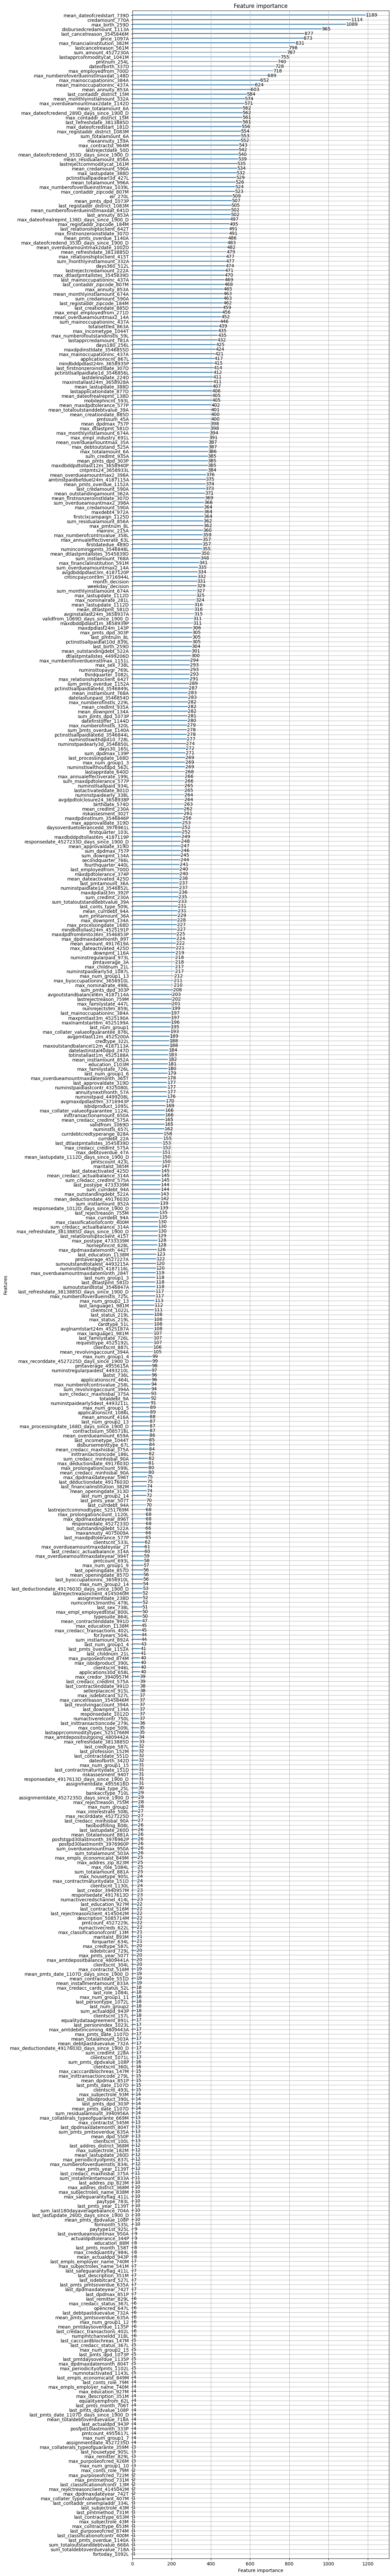

In [13]:
lgb.plot_importance(fitted_models[best_idx], importance_type="split", figsize=(10, 100))
plt.show()

In [14]:
best_model = fitted_models[best_idx]

# 获取Booster对象
booster = best_model.booster_

# 获取特征重要性
importances = booster.feature_importance(importance_type="split")

# 获取特征名称
feature_names = booster.feature_name()

# 将特征名称和重要性组合成字典
feature_importances_dict = dict(zip(feature_names, importances))

# 打印字典
less_important_features = [key for key, value in feature_importances_dict.items() if value ==0]

print(less_important_features)

for key, value in feature_importances_dict.items():
    if key.endswith('M') and key.startswith('max'):
        print(f"{key}: {value}")

['applicationcnt_361L', 'clientscnt_257L', 'deferredmnthsnum_166L', 'sum_installmentamount_644A', 'sum_residualamount_1093A', 'last_num_group1_7', 'for3years_128L', 'for3years_584L', 'formonth_118L', 'formonth_206L', 'forquarter_1017L', 'forquarter_462L', 'forweek_1077L', 'forweek_528L', 'forweek_601L', 'foryear_818L', 'commnoinclast6m_3546845L', 'mastercontrelectronic_519L', 'mastercontrexist_109L', 'mean_outstandingamount_354A', 'mean_overdueamount_31A', 'max_pmts_month_158T', 'max_residualamount_488A', 'mean_totaloutstanddebtvalue_668A', 'sum_outstandingamount_354A', 'sum_residualamount_488A', 'max_numberofoutstandinstls_520L', 'max_installmentamount_644A', 'max_num_group1_8', 'last_num_group1_8', 'sum_last180dayturnover_1134A', 'sum_last30dayturnover_651A', 'max_pmts_month_706T', 'max_profession_152M', 'last_contractst_545M', 'last_contractst_964M', 'last_financialinstitution_591M', 'last_purposeofcred_426M', 'last_subjectrole_182M', 'last_subjectrole_93M', 'max_classificationofcon

In [15]:
import joblib

joblib.dump(fitted_models, 'lgb_models.joblib')

['lgb_models.joblib']